# Practical Statistics for Data Scientists (R)
# Chapter 4. Regression and Prediction
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required R packages.

In [1]:
library(MASS)
library(dplyr)
library(tidyr)
library(ggplot2)
library(lubridate)
library(splines)
library(mgcv)

Warning message:
“package ‘MASS’ was built under R version 4.1.3”


Warning message:
“package ‘dplyr’ was built under R version 4.1.2”



Attaching package: ‘dplyr’




The following object is masked from ‘package:MASS’:

    select




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Warning message:
“package ‘tidyr’ was built under R version 4.1.2”



Attaching package: ‘lubridate’




The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Warning message:
“package ‘mgcv’ was built under R version 4.1.3”


Loading required package: nlme



Warning message:
“package ‘nlme’ was built under R version 4.1.2”



Attaching package: ‘nlme’




The following object is masked from ‘package:dplyr’:

    collapse




This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.



Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
PSDS_PATH <- file.path(dirname(dirname(getwd())))


lung <- read.csv(file.path(PSDS_PATH, 'data', 'LungDisease.csv'))
house <- read.csv(file.path(PSDS_PATH, 'data', 'house_sales.csv'), sep='\t')

# Simple Linear Regression
## The Regression Equation

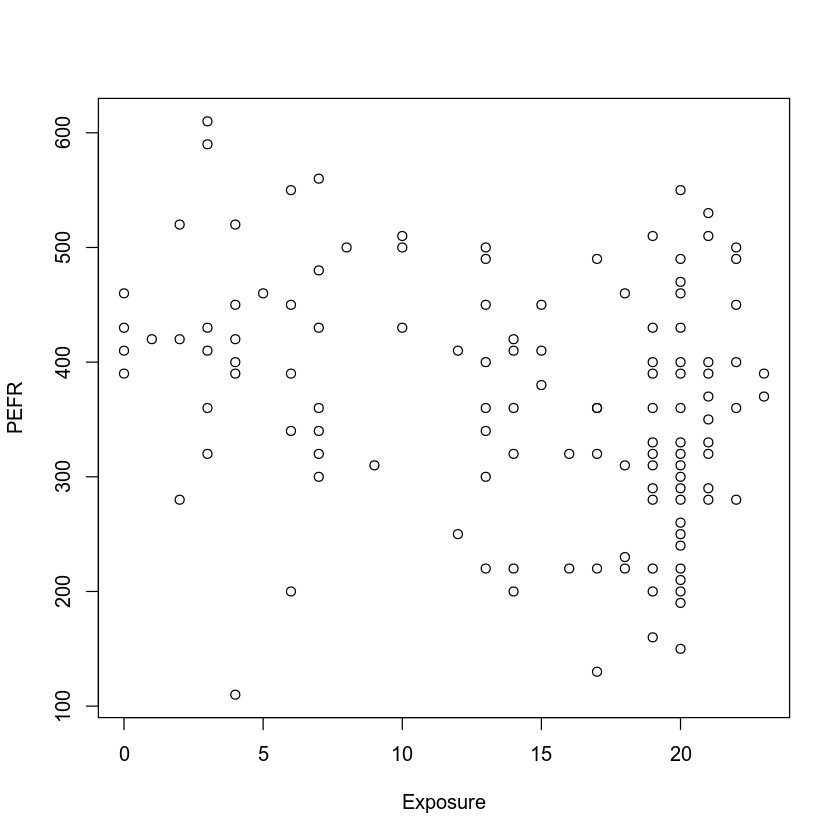

In [3]:
plot(lung$Exposure, lung$PEFR, xlab="Exposure", ylab="PEFR")

In [4]:
model <- lm(PEFR ~ Exposure, data=lung)
model


Call:
lm(formula = PEFR ~ Exposure, data = lung)

Coefficients:
(Intercept)     Exposure  
    424.583       -4.185  


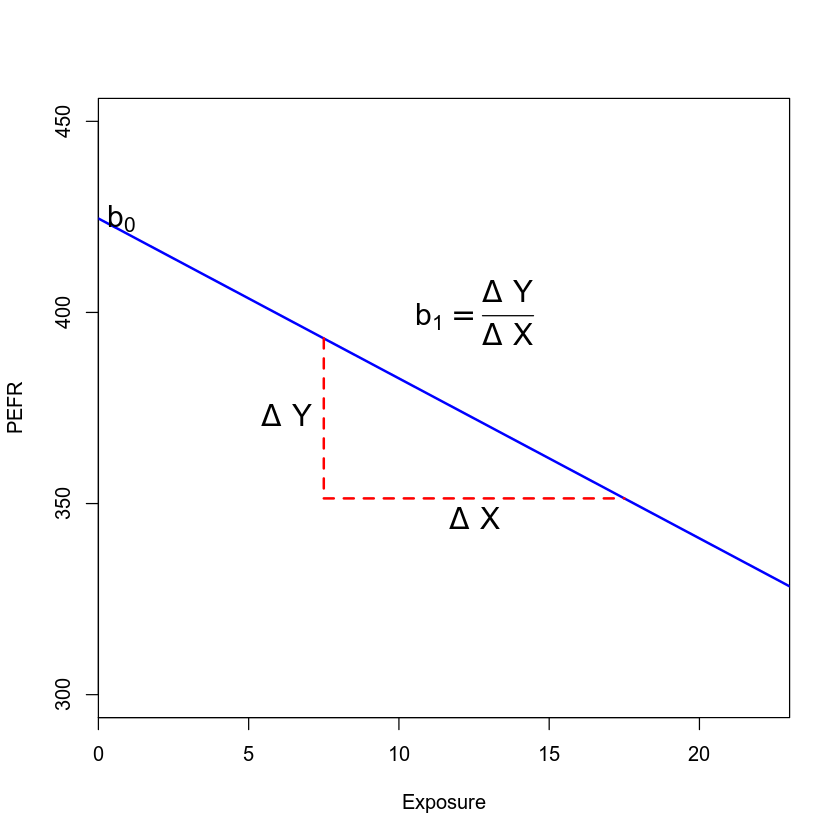

In [5]:
plot(lung$Exposure, lung$PEFR, xlab="Exposure", ylab="PEFR", ylim=c(300,450), type="n", xaxs="i")
abline(a=model$coefficients[1], b=model$coefficients[2], col="blue", lwd=2)
text(x=.3, y=model$coefficients[1], labels=expression("b"[0]),  adj=0, cex=1.5)
x <- c(7.5, 17.5)
y <- predict(model, newdata=data.frame(Exposure=x))
segments(x[1], y[2], x[2], y[2] , col="red", lwd=2, lty=2)
segments(x[1], y[1], x[1], y[2] , col="red", lwd=2, lty=2)
text(x[1], mean(y), labels=expression(Delta~Y), pos=2, cex=1.5)
text(mean(x), y[2], labels=expression(Delta~X), pos=1, cex=1.5)
text(mean(x), 400, labels=expression(b[1] == frac(Delta ~ Y, Delta ~ X)), cex=1.5)

## Fitted Values and Residuals

In [6]:
fitted <- predict(model)
resid <- residuals(model)

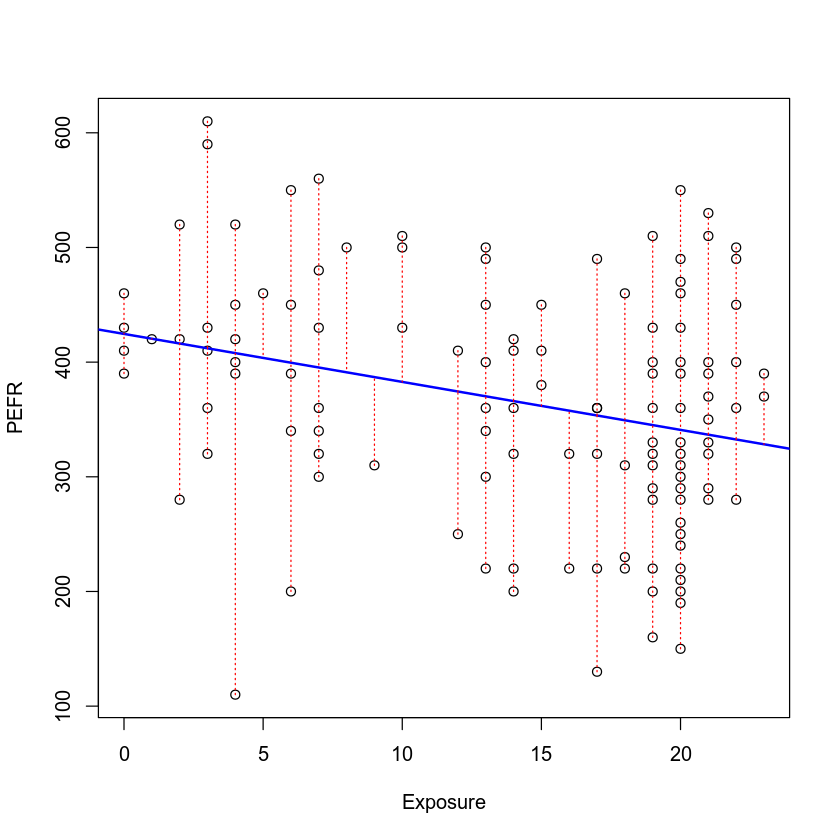

In [7]:
lung1 <- lung %>%
  mutate(Fitted=fitted,
         positive = PEFR>Fitted) %>%
  group_by(Exposure, positive) %>%
  summarize(PEFR_max = max(PEFR), 
            PEFR_min = min(PEFR),
            Fitted = first(Fitted), 
            .groups='keep') %>%
  ungroup() %>%
  mutate(PEFR = ifelse(positive, PEFR_max, PEFR_min)) %>%
  arrange(Exposure)

plot(lung$Exposure, lung$PEFR, xlab="Exposure", ylab="PEFR")
abline(a=model$coefficients[1], b=model$coefficients[2], col="blue", lwd=2)
segments(lung1$Exposure, lung1$PEFR, lung1$Exposure, lung1$Fitted, col="red", lty=3)

# Multiple linear regression

In [8]:
print(head(house[, c('AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
               'Bedrooms', 'BldgGrade')]))

  AdjSalePrice SqFtTotLiving SqFtLot Bathrooms Bedrooms BldgGrade
1       300805          2400    9373      3.00        6         7
2      1076162          3764   20156      3.75        4        10
3       761805          2060   26036      1.75        4         8
4       442065          3200    8618      3.75        5         7
5       297065          1720    8620      1.75        4         7
6       411781           930    1012      1.50        2         8


In [9]:
house_lm <- lm(AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
                 Bedrooms + BldgGrade,  
               data=house, na.action=na.omit)

house_lm


Call:
lm(formula = AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
    Bedrooms + BldgGrade, data = house, na.action = na.omit)

Coefficients:
  (Intercept)  SqFtTotLiving        SqFtLot      Bathrooms       Bedrooms  
   -5.219e+05      2.288e+02     -6.047e-02     -1.944e+04     -4.777e+04  
    BldgGrade  
    1.061e+05  


## Assessing the Model

In [10]:
summary(house_lm)


Call:
lm(formula = AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
    Bedrooms + BldgGrade, data = house, na.action = na.omit)

Residuals:
     Min       1Q   Median       3Q      Max 
-1199479  -118908   -20977    87435  9473035 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -5.219e+05  1.565e+04 -33.342  < 2e-16 ***
SqFtTotLiving  2.288e+02  3.899e+00  58.694  < 2e-16 ***
SqFtLot       -6.047e-02  6.118e-02  -0.988    0.323    
Bathrooms     -1.944e+04  3.625e+03  -5.363 8.27e-08 ***
Bedrooms      -4.777e+04  2.490e+03 -19.187  < 2e-16 ***
BldgGrade      1.061e+05  2.396e+03  44.277  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 261300 on 22681 degrees of freedom
Multiple R-squared:  0.5406,	Adjusted R-squared:  0.5405 
F-statistic:  5338 on 5 and 22681 DF,  p-value: < 2.2e-16


## Model Selection and Stepwise Regression

In [11]:
house_full <- lm(AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
                   Bedrooms + BldgGrade + PropertyType + NbrLivingUnits + 
                   SqFtFinBasement + YrBuilt + YrRenovated + NewConstruction,
                 data=house, na.action=na.omit)

## Code snippet 4.8
step_lm <- stepAIC(house_full, direction="both")
step_lm

Start:  AIC=563145.4
AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + 
    BldgGrade + PropertyType + NbrLivingUnits + SqFtFinBasement + 
    YrBuilt + YrRenovated + NewConstruction



                  Df  Sum of Sq        RSS    AIC
- NbrLivingUnits   1 6.4007e+09 1.3662e+15 563144
- NewConstruction  1 1.0592e+10 1.3662e+15 563144
- YrRenovated      1 2.5069e+10 1.3662e+15 563144
- SqFtLot          1 1.0657e+11 1.3663e+15 563145
<none>                          1.3662e+15 563145
- SqFtFinBasement  1 1.4030e+11 1.3663e+15 563146
- PropertyType     2 4.4207e+12 1.3706e+15 563215
- Bathrooms        1 7.6325e+12 1.3738e+15 563270
- Bedrooms         1 2.8212e+13 1.3944e+15 563607
- YrBuilt          1 1.2906e+14 1.4952e+15 565191
- SqFtTotLiving    1 1.3264e+14 1.4988e+15 565246
- BldgGrade        1 1.9050e+14 1.5567e+15 566105



Step:  AIC=563143.6
AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + 
    BldgGrade + PropertyType + SqFtFinBasement + YrBuilt + YrRenovated + 
    NewConstruction



                  Df  Sum of Sq        RSS    AIC
- NewConstruction  1 1.0801e+10 1.3662e+15 563142
- YrRenovated      1 2.5628e+10 1.3662e+15 563142
- SqFtLot          1 1.0731e+11 1.3663e+15 563143
<none>                          1.3662e+15 563144
- SqFtFinBasement  1 1.3828e+11 1.3663e+15 563144
+ NbrLivingUnits   1 6.4007e+09 1.3662e+15 563145
- PropertyType     2 4.4301e+12 1.3706e+15 563213
- Bathrooms        1 7.7500e+12 1.3739e+15 563270
- Bedrooms         1 2.8273e+13 1.3944e+15 563606
- YrBuilt          1 1.3013e+14 1.4963e+15 565206
- SqFtTotLiving    1 1.3288e+14 1.4990e+15 565247
- BldgGrade        1 1.9177e+14 1.5579e+15 566122



Step:  AIC=563141.7
AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + 
    BldgGrade + PropertyType + SqFtFinBasement + YrBuilt + YrRenovated



                  Df  Sum of Sq        RSS    AIC
- YrRenovated      1 2.5893e+10 1.3662e+15 563140
- SqFtLot          1 1.1494e+11 1.3663e+15 563142
<none>                          1.3662e+15 563142
- SqFtFinBasement  1 1.4534e+11 1.3663e+15 563142
+ NewConstruction  1 1.0801e+10 1.3662e+15 563144
+ NbrLivingUnits   1 6.6093e+09 1.3662e+15 563144
- PropertyType     2 4.5301e+12 1.3707e+15 563213
- Bathrooms        1 7.7487e+12 1.3739e+15 563268
- Bedrooms         1 2.8269e+13 1.3945e+15 563604
- SqFtTotLiving    1 1.3390e+14 1.5001e+15 565261
- YrBuilt          1 1.3760e+14 1.5038e+15 565317
- BldgGrade        1 1.9244e+14 1.5586e+15 566129



Step:  AIC=563140.2
AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + 
    BldgGrade + PropertyType + SqFtFinBasement + YrBuilt



                  Df  Sum of Sq        RSS    AIC
- SqFtLot          1 1.1425e+11 1.3663e+15 563140
<none>                          1.3662e+15 563140
- SqFtFinBasement  1 1.4999e+11 1.3664e+15 563141
+ YrRenovated      1 2.5893e+10 1.3662e+15 563142
+ NewConstruction  1 1.1065e+10 1.3662e+15 563142
+ NbrLivingUnits   1 7.1825e+09 1.3662e+15 563142
- PropertyType     2 4.5076e+12 1.3707e+15 563211
- Bathrooms        1 7.7790e+12 1.3740e+15 563267
- Bedrooms         1 2.8251e+13 1.3945e+15 563603
- SqFtTotLiving    1 1.3388e+14 1.5001e+15 565259
- YrBuilt          1 1.5091e+14 1.5171e+15 565515
- BldgGrade        1 1.9244e+14 1.5587e+15 566128



Step:  AIC=563140.1
AdjSalePrice ~ SqFtTotLiving + Bathrooms + Bedrooms + BldgGrade + 
    PropertyType + SqFtFinBasement + YrBuilt



                  Df  Sum of Sq        RSS    AIC
<none>                          1.3663e+15 563140
+ SqFtLot          1 1.1425e+11 1.3662e+15 563140
- SqFtFinBasement  1 1.4116e+11 1.3665e+15 563140
+ YrRenovated      1 2.5199e+10 1.3663e+15 563142
+ NewConstruction  1 1.8750e+10 1.3663e+15 563142
+ NbrLivingUnits   1 8.0521e+09 1.3663e+15 563142
- PropertyType     2 4.4415e+12 1.3708e+15 563210
- Bathrooms        1 7.7109e+12 1.3740e+15 563266
- Bedrooms         1 2.8553e+13 1.3949e+15 563607
- SqFtTotLiving    1 1.3748e+14 1.5038e+15 565313
- YrBuilt          1 1.5080e+14 1.5171e+15 565513
- BldgGrade        1 1.9234e+14 1.5587e+15 566126



Call:
lm(formula = AdjSalePrice ~ SqFtTotLiving + Bathrooms + Bedrooms + 
    BldgGrade + PropertyType + SqFtFinBasement + YrBuilt, data = house, 
    na.action = na.omit)

Coefficients:
              (Intercept)              SqFtTotLiving  
                6.179e+06                  1.993e+02  
                Bathrooms                   Bedrooms  
                4.240e+04                 -5.195e+04  
                BldgGrade  PropertyTypeSingle Family  
                1.372e+05                  2.291e+04  
    PropertyTypeTownhouse            SqFtFinBasement  
                8.448e+04                  7.047e+00  
                  YrBuilt  
               -3.565e+03  


In [12]:
lm(AdjSalePrice ~  Bedrooms, data=house)


Call:
lm(formula = AdjSalePrice ~ Bedrooms, data = house)

Coefficients:
(Intercept)     Bedrooms  
     117354       132991  


## Weighted regression

In [13]:
house$Year = year(house$DocumentDate)
house$Weight = house$Year - 2005

house_wt <- lm(AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
                 Bedrooms + BldgGrade,
               data=house, weight=Weight, na.action=na.omit)
round(cbind(house_lm=house_lm$coefficients, 
            house_wt=house_wt$coefficients), digits=3)

,house_lm,house_wt
(Intercept),-521871.368,-584189.329
SqFtTotLiving,228.831,245.024
SqFtLot,-0.060,-0.292
Bathrooms,-19442.840,-26085.970
Bedrooms,-47769.955,-53608.876
BldgGrade,106106.963,115242.435


# Factor variables in regression
## Dummy Variables Representation

In [14]:
head(house[, 'PropertyType'])

[1] "Multiplex"     "Single Family" "Single Family" "Single Family"
[5] "Single Family" "Townhouse"

In [15]:
prop_type_dummies <- model.matrix(~PropertyType -1, data=house)
head(prop_type_dummies)

,PropertyTypeMultiplex,PropertyTypeSingle Family,PropertyTypeTownhouse
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0
6,0,0,1


In [16]:
lm(AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
     Bedrooms +  BldgGrade + PropertyType, data=house)


Call:
lm(formula = AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
    Bedrooms + BldgGrade + PropertyType, data = house)

Coefficients:
              (Intercept)              SqFtTotLiving  
               -4.468e+05                  2.234e+02  
                  SqFtLot                  Bathrooms  
               -7.037e-02                 -1.598e+04  
                 Bedrooms                  BldgGrade  
               -5.089e+04                  1.094e+05  
PropertyTypeSingle Family      PropertyTypeTownhouse  
               -8.468e+04                 -1.151e+05  


## Factor Variables with many levels

In [17]:
table(house$ZipCode)


98001 98002 98003 98004 98005 98006 98007 98008 98010 98011 98014 98019 98022 
  358   180   241   293   133   460   112   291    56   163    85   242   188 
98023 98024 98027 98028 98029 98030 98031 98032 98033 98034 98038 98039 98040 
  455    31   366   252   475   263   308   121   517   575   788    47   244 
98042 98043 98045 98047 98050 98051 98052 98053 98055 98056 98057 98058 98059 
  641     1   222    48     7    32   614   499   332   402     4   420   513 
98065 98068 98070 98072 98074 98075 98077 98092 98102 98103 98105 98106 98107 
  430     1    89   245   502   388   204   289   106   671   313   361   296 
98108 98109 98112 98113 98115 98116 98117 98118 98119 98122 98125 98126 98133 
  155   149   357     1   620   364   619   492   260   380   409   473   465 
98136 98144 98146 98148 98155 98166 98168 98177 98178 98188 98198 98199 98224 
  310   332   287    40   358   193   332   216   266   101   225   393     3 
98288 98354 
    4     9 

In [18]:
zip_groups <- house %>%
  mutate(resid = residuals(house_lm)) %>%
  group_by(ZipCode) %>%
  summarize(med_resid = median(resid),
            cnt = n()) %>%
  # sort the zip codes by the median residual
  arrange(med_resid) %>%
  mutate(cum_cnt = cumsum(cnt),
         ZipGroup = factor(ntile(cum_cnt, 5)))
house <- house %>%
  left_join(select(zip_groups, ZipCode, ZipGroup), by='ZipCode')

In [19]:
table(zip_groups[c('ZipGroup')])


 1  2  3  4  5 
16 16 16 16 16 

# Interpreting the Regression Equation
## Correlated predictors

The results from the stepwise regression are.

In [20]:
step_lm$coefficients

(Intercept)             SqFtTotLiving                 Bathrooms 
             6.178645e+06              1.992776e+02              4.239616e+04 
                 Bedrooms                 BldgGrade PropertyTypeSingle Family 
            -5.194738e+04              1.371596e+05              2.291206e+04 
    PropertyTypeTownhouse           SqFtFinBasement                   YrBuilt 
             8.447916e+04              7.046975e+00             -3.565425e+03

In [21]:
update(step_lm, . ~ . -SqFtTotLiving - SqFtFinBasement - Bathrooms)


Call:
lm(formula = AdjSalePrice ~ Bedrooms + BldgGrade + PropertyType + 
    YrBuilt, data = house, na.action = na.omit)

Coefficients:
              (Intercept)                   Bedrooms  
                  4913973                      27151  
                BldgGrade  PropertyTypeSingle Family  
                   248998                     -19898  
    PropertyTypeTownhouse                    YrBuilt  
                   -47355                      -3212  


## Confounding variables

In [22]:
lm(AdjSalePrice ~  SqFtTotLiving + SqFtLot + 
     Bathrooms + Bedrooms + 
     BldgGrade + PropertyType + ZipGroup,
   data=house, na.action=na.omit)


Call:
lm(formula = AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
    Bedrooms + BldgGrade + PropertyType + ZipGroup, data = house, 
    na.action = na.omit)

Coefficients:
              (Intercept)              SqFtTotLiving  
               -6.666e+05                  2.106e+02  
                  SqFtLot                  Bathrooms  
                4.550e-01                  5.928e+03  
                 Bedrooms                  BldgGrade  
               -4.168e+04                  9.854e+04  
PropertyTypeSingle Family      PropertyTypeTownhouse  
                1.932e+04                 -7.820e+04  
                ZipGroup2                  ZipGroup3  
                5.332e+04                  1.163e+05  
                ZipGroup4                  ZipGroup5  
                1.784e+05                  3.384e+05  


## Interactions and Main Effects

In [23]:
lm(AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + 
     Bathrooms + Bedrooms + 
     BldgGrade + PropertyType,
   data=house, na.action=na.omit)


Call:
lm(formula = AdjSalePrice ~ SqFtTotLiving * ZipGroup + SqFtLot + 
    Bathrooms + Bedrooms + BldgGrade + PropertyType, data = house, 
    na.action = na.omit)

Coefficients:
              (Intercept)              SqFtTotLiving  
               -4.853e+05                  1.148e+02  
                ZipGroup2                  ZipGroup3  
               -1.113e+04                  2.032e+04  
                ZipGroup4                  ZipGroup5  
                2.050e+04                 -1.499e+05  
                  SqFtLot                  Bathrooms  
                6.869e-01                 -3.619e+03  
                 Bedrooms                  BldgGrade  
               -4.180e+04                  1.047e+05  
PropertyTypeSingle Family      PropertyTypeTownhouse  
                1.357e+04                 -5.884e+04  
  SqFtTotLiving:ZipGroup2    SqFtTotLiving:ZipGroup3  
                3.260e+01                  4.178e+01  
  SqFtTotLiving:ZipGroup4    SqFtTotLiving:ZipGro

# Testing the Assumptions: Regression Diagnostics
## Outliers

In [24]:
house_98105 <- house[house$ZipCode == 98105,]
lm_98105 <- lm(AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
                 Bedrooms + BldgGrade, data=house_98105)

In [25]:
summary(lm_98105)


Call:
lm(formula = AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + 
    Bedrooms + BldgGrade, data = house_98105)

Residuals:
    Min      1Q  Median      3Q     Max 
-757754  -91807   -9668   77586  953911 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -772549.86   98277.27  -7.861 6.51e-14 ***
SqFtTotLiving     209.60      24.41   8.587 4.54e-16 ***
SqFtLot            38.93       5.33   7.305 2.41e-12 ***
Bathrooms        2282.26   19983.57   0.114   0.9091    
Bedrooms       -26320.27   12881.09  -2.043   0.0419 *  
BldgGrade      130000.10   15234.12   8.533 6.63e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 178500 on 307 degrees of freedom
Multiple R-squared:  0.7954,	Adjusted R-squared:  0.7921 
F-statistic: 238.7 on 5 and 307 DF,  p-value: < 2.2e-16


In [26]:
sresid <- rstandard(lm_98105)
idx <- order(sresid, decreasing=FALSE)
sresid[idx[1]]
resid(lm_98105)[idx[1]]

20429 
-4.326732

20429 
-757753.6

In [27]:
house_98105[idx[1], c('AdjSalePrice', 'SqFtTotLiving', 'SqFtLot',
                      'Bathrooms', 'Bedrooms', 'BldgGrade')]

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
,<dbl>,<int>,<int>,<dbl>,<int>,<int>
20429,119748,2900,7276,3,6,7


## Influential values

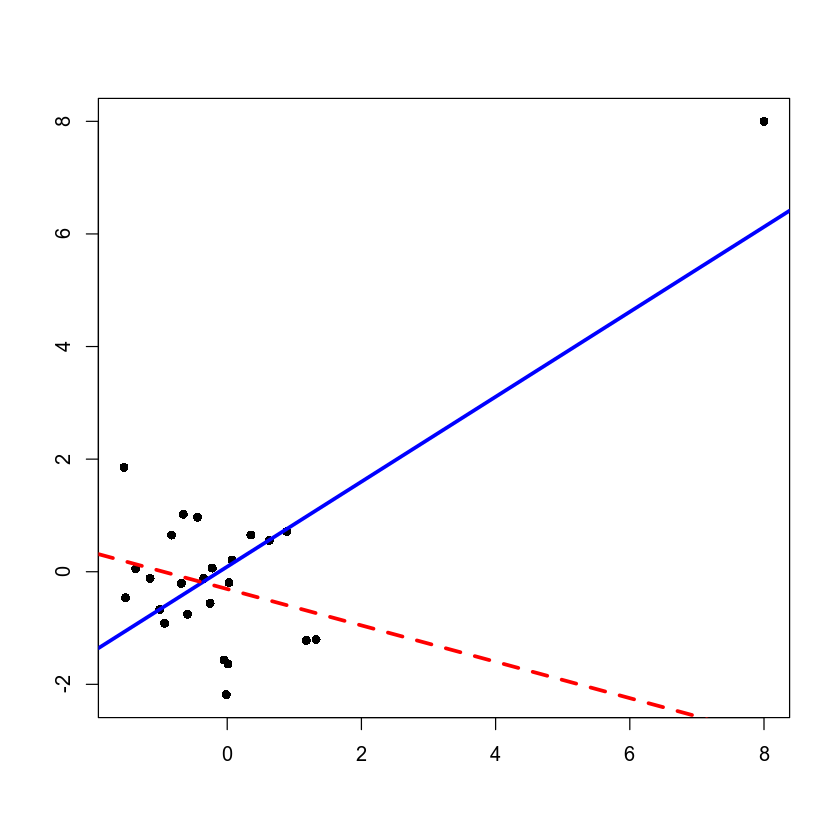

In [28]:
seed <- 11
set.seed(seed)
x <- rnorm(25)
y <- -x/5 + rnorm(25)
x[1] <- 8
y[1] <- 8

plot(x, y, xlab='', ylab='', pch=16)
model <- lm(y~x)
abline(a=model$coefficients[1], b=model$coefficients[2], col="blue", lwd=3)
model <- lm(y[-1]~x[-1])
abline(a=model$coefficients[1], b=model$coefficients[2], col="red", lwd=3, lty=2)

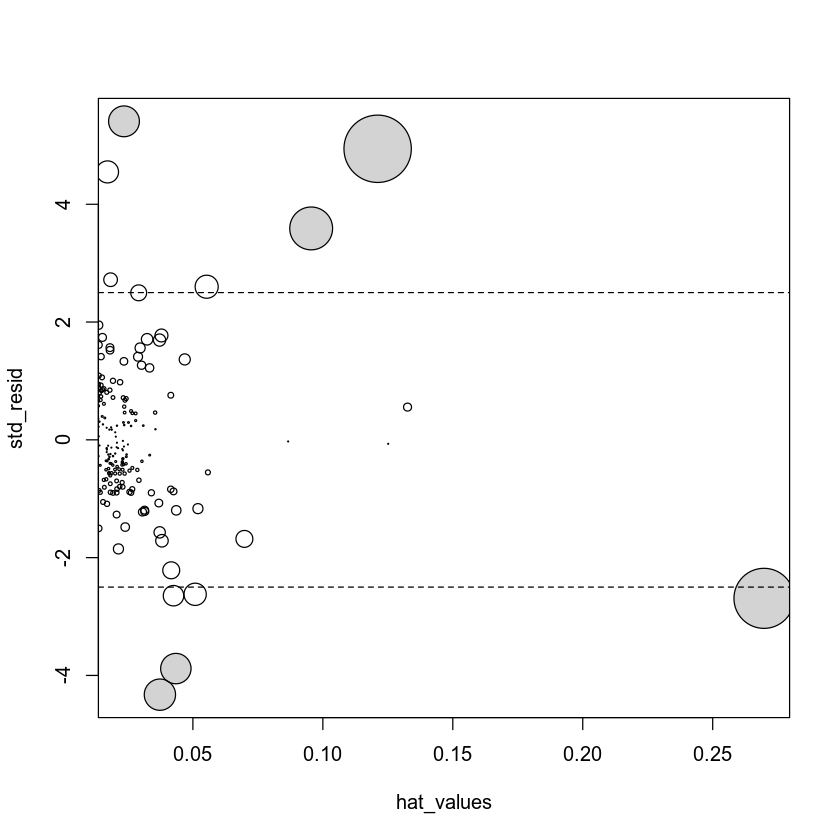

In [29]:
# influential observations
std_resid <- rstandard(lm_98105)
cooks_D <- cooks.distance(lm_98105)
hat_values <- hatvalues(lm_98105)
plot(subset(hat_values, cooks_D > 0.08), subset(std_resid, cooks_D > 0.08), 
     xlab='hat_values', ylab='std_resid',
     cex=10*sqrt(subset(cooks_D, cooks_D > 0.08)), pch=16, col='lightgrey')
points(hat_values, std_resid, cex=10*sqrt(cooks_D))
abline(h=c(-2.5, 2.5), lty=2)

In [30]:
lm_98105_inf <- lm(AdjSalePrice ~ SqFtTotLiving + SqFtLot + 
                     Bathrooms +  Bedrooms + BldgGrade,
                   subset=cooks_D<.08, data=house_98105)

## Heteroskedasticity, Non-Normality and Correlated Errors

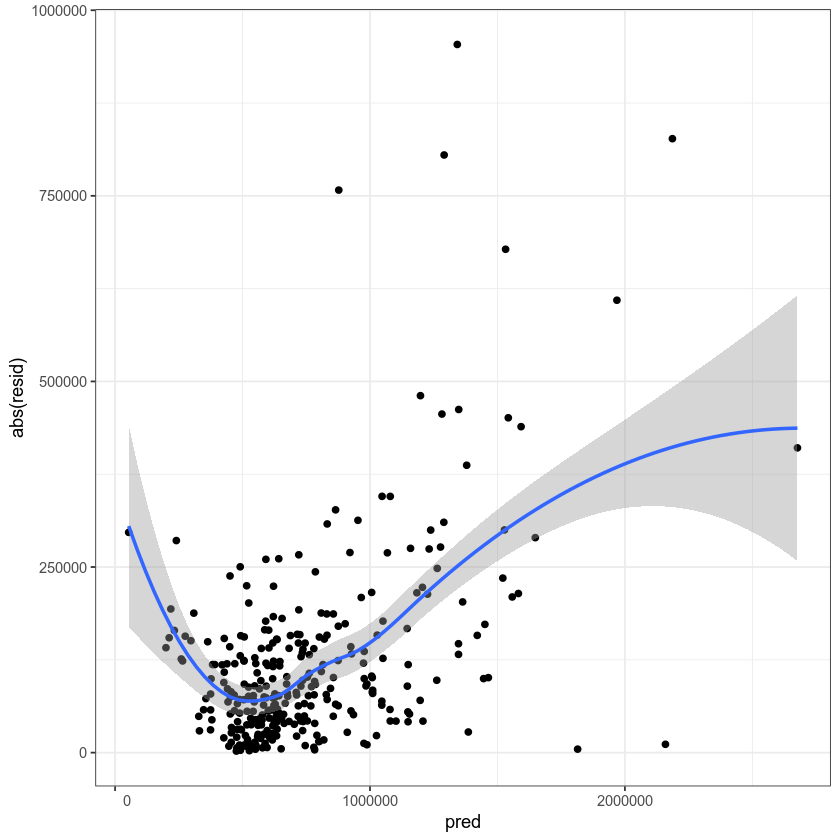

In [31]:
df <- data.frame(
  resid = residuals(lm_98105),
  pred = predict(lm_98105))

graph <- ggplot(df, aes(pred, abs(resid))) +
  geom_point() +
  geom_smooth(formula=y~x, method='loess') +
  scale_x_continuous(labels = function(x) format(x, scientific = FALSE)) +
  theme_bw()
graph

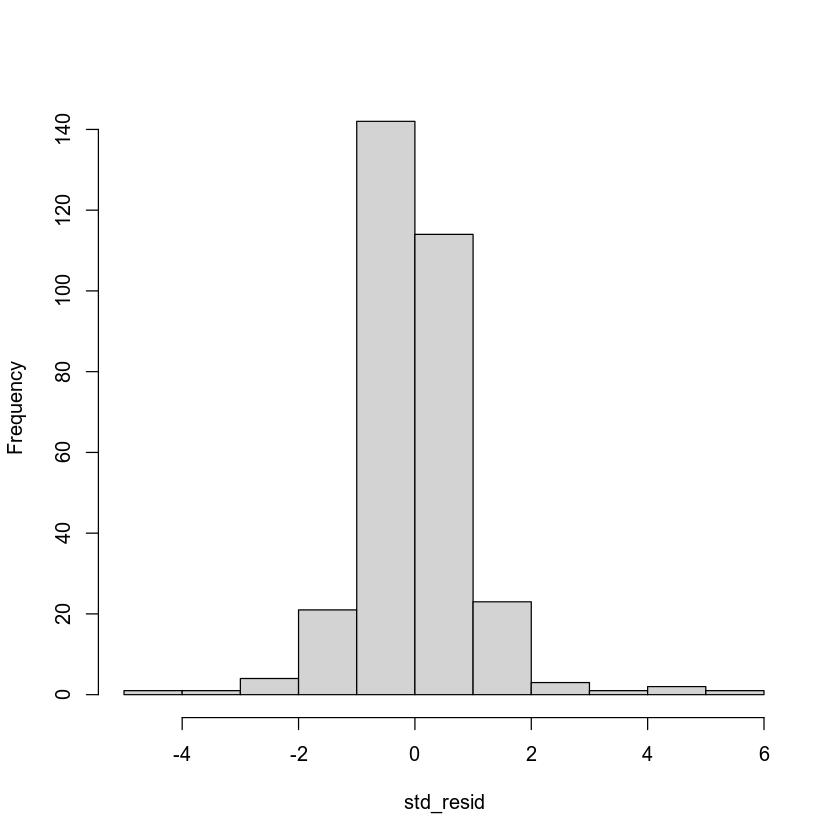

In [32]:
hist(std_resid, main='')

## Partial Residual Plots and Nonlinearity

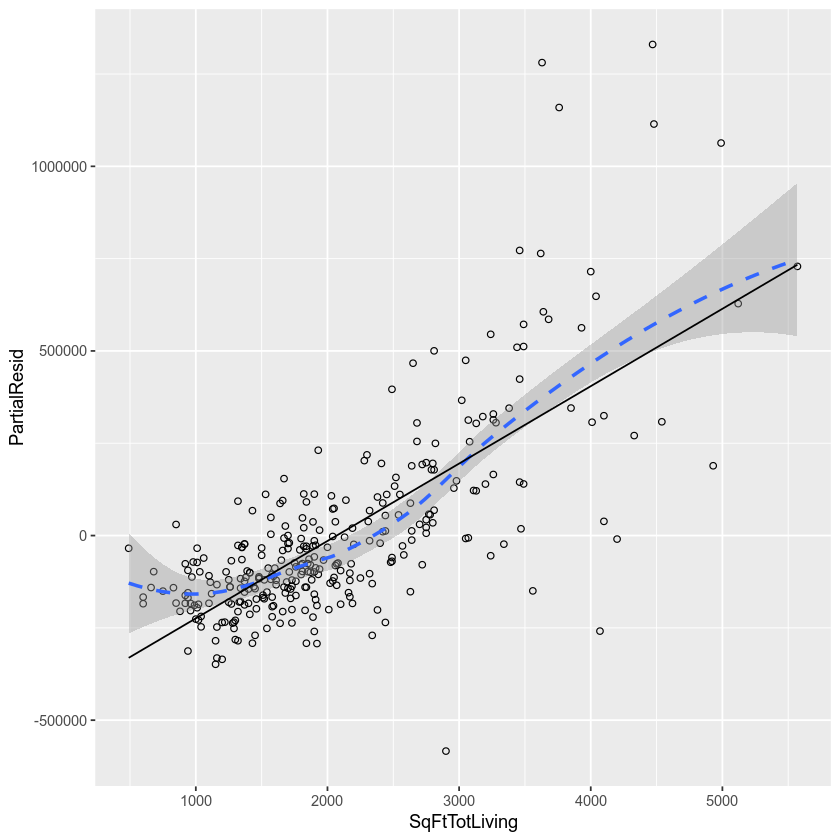

In [33]:
terms <- predict(lm_98105, type='terms')
partial_resid <- resid(lm_98105) + terms

df <- data.frame(SqFtTotLiving = house_98105[, 'SqFtTotLiving'],
                 Terms = terms[, 'SqFtTotLiving'],
                 PartialResid = partial_resid[, 'SqFtTotLiving'])
graph <- ggplot(df, aes(SqFtTotLiving, PartialResid)) +
  geom_point(shape=1) + scale_shape(solid = FALSE) +
  geom_smooth(linetype=2, formula=y~x, method='loess') + 
  geom_line(aes(SqFtTotLiving, Terms)) + 
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))
graph

## Polynomial and Spline Regression

In [34]:
lm_poly <- lm(AdjSalePrice ~  poly(SqFtTotLiving, 2) + SqFtLot + 
                BldgGrade +  Bathrooms +  Bedrooms,
              data=house_98105)
terms <- predict(lm_poly, type='terms')
partial_resid <- resid(lm_poly) + terms
lm_poly


Call:
lm(formula = AdjSalePrice ~ poly(SqFtTotLiving, 2) + SqFtLot + 
    BldgGrade + Bathrooms + Bedrooms, data = house_98105)

Coefficients:
            (Intercept)  poly(SqFtTotLiving, 2)1  poly(SqFtTotLiving, 2)2  
             -402530.47               3271519.49                776934.02  
                SqFtLot                BldgGrade                Bathrooms  
                  32.56                135717.06                 -1435.12  
               Bedrooms  
               -9191.94  


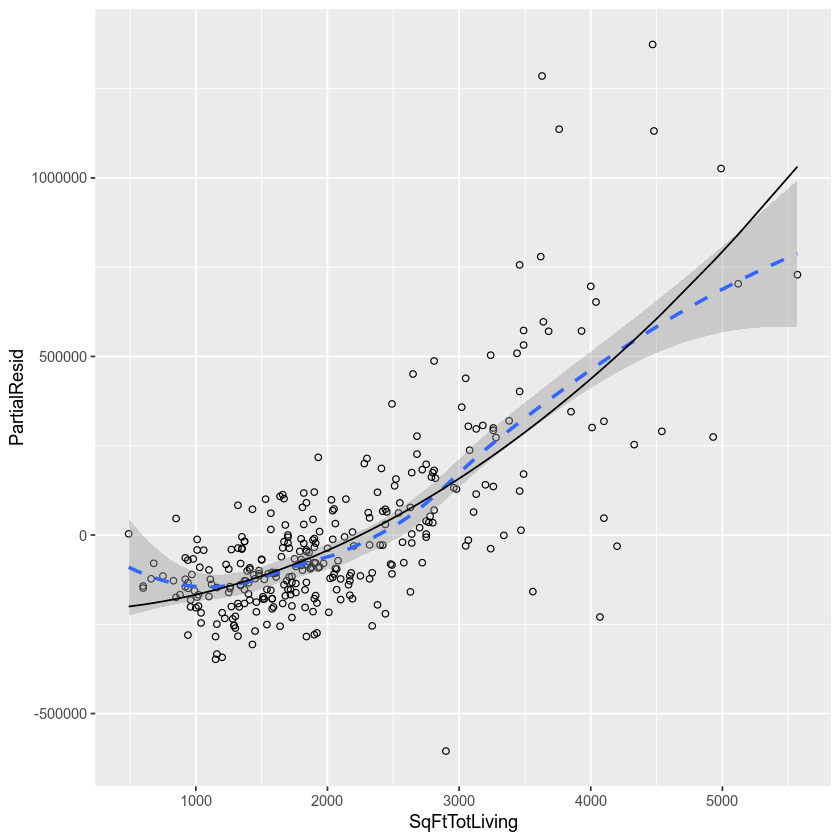

In [35]:
df <- data.frame(SqFtTotLiving = house_98105[, 'SqFtTotLiving'],
                 Terms = terms[, 1],
                 PartialResid = partial_resid[, 1])
graph <- ggplot(df, aes(SqFtTotLiving, PartialResid)) +
  geom_point(shape=1) + scale_shape(solid = FALSE) +
  geom_smooth(linetype=2, formula=y~x, method='loess') + 
  geom_line(aes(SqFtTotLiving, Terms)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))
graph

## Splines

In [36]:
knots <- quantile(house_98105$SqFtTotLiving, p=c(.25, .5, .75))
lm_spline <- lm(AdjSalePrice ~ bs(SqFtTotLiving, knots=knots, degree=3) +  SqFtLot +  
                  Bathrooms + Bedrooms + BldgGrade,  data=house_98105)
lm_spline

terms1 <- predict(lm_spline, type='terms')
partial_resid1 <- resid(lm_spline) + terms1


Call:
lm(formula = AdjSalePrice ~ bs(SqFtTotLiving, knots = knots, 
    degree = 3) + SqFtLot + Bathrooms + Bedrooms + BldgGrade, 
    data = house_98105)

Coefficients:
                                  (Intercept)  
                                   -414157.61  
bs(SqFtTotLiving, knots = knots, degree = 3)1  
                                   -199529.76  
bs(SqFtTotLiving, knots = knots, degree = 3)2  
                                   -120580.64  
bs(SqFtTotLiving, knots = knots, degree = 3)3  
                                    -71644.39  
bs(SqFtTotLiving, knots = knots, degree = 3)4  
                                    195677.89  
bs(SqFtTotLiving, knots = knots, degree = 3)5  
                                    845244.25  
bs(SqFtTotLiving, knots = knots, degree = 3)6  
                                    695545.67  
                                      SqFtLot  
                                        33.33  
                                    Bathrooms  
             

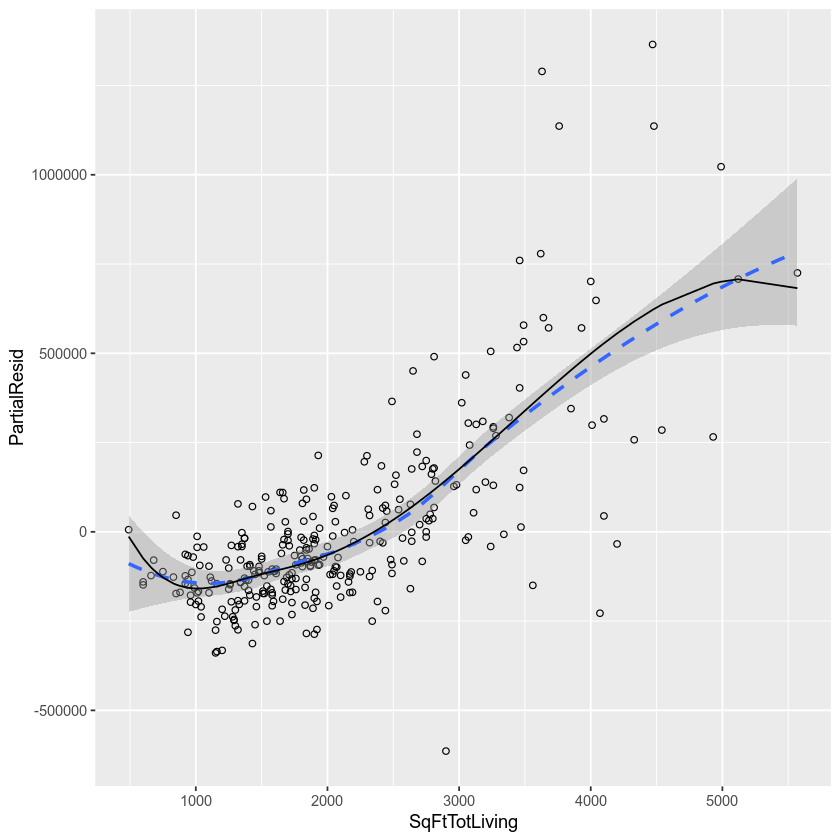

In [37]:
df1 <- data.frame(SqFtTotLiving = house_98105[, 'SqFtTotLiving'],
                 Terms = terms1[, 1],
                 PartialResid = partial_resid1[, 1])

graph <- ggplot(df1, aes(SqFtTotLiving, PartialResid)) +
  geom_point(shape=1) + scale_shape(solid = FALSE) +
  geom_smooth(linetype=2, formula=y~x, method='loess') + 
  geom_line(aes(SqFtTotLiving, Terms)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))
graph

## Generalized Additive Models

In [38]:
lm_gam <- gam(AdjSalePrice ~ s(SqFtTotLiving) + SqFtLot + 
              Bathrooms +  Bedrooms + BldgGrade, 
              data=house_98105)
terms <- predict.gam(lm_gam, type='terms')
partial_resid <- resid(lm_gam) + terms
lm_gam


Family: gaussian 
Link function: identity 

Formula:
AdjSalePrice ~ s(SqFtTotLiving) + SqFtLot + Bathrooms + Bedrooms + 
    BldgGrade

Estimated degrees of freedom:
4.49  total = 9.49 

GCV score: 30148051324     

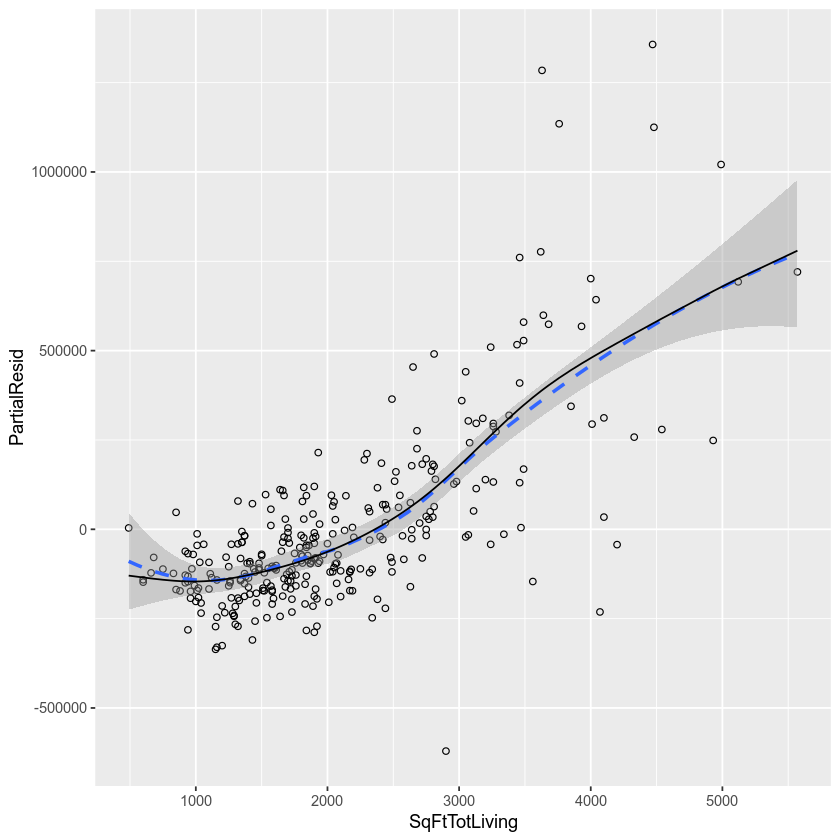

In [39]:
df <- data.frame(SqFtTotLiving = house_98105[, 'SqFtTotLiving'],
                 Terms = terms[, 5],
                 PartialResid = partial_resid[, 5])
graph <- ggplot(df, aes(SqFtTotLiving, PartialResid)) +
  geom_point(shape=1) + scale_shape(solid = FALSE) +
  geom_smooth(linetype=2, formula=y~x, method='loess') + 
  geom_line(aes(SqFtTotLiving, Terms)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))
graph